In [ ]:
import zipfile
import pandas as pd
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pylab import rcParams

Загрузим данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = '/content/drive/MyDrive/Data/FakeNameGenerator.com_48e7a6a2.csv'

In [ ]:
df = pd.read_csv(file)

In [ ]:
df_ = df[['GivenName', 'Surname', 'NameSet']].copy()

In [ ]:
df_.columns = ['Name', 'Surname', 'Nationality']

Проанализируем данные

In [ ]:
df_.head(10)

,Name,Surname,Nationality
0,Rhys,May,England/Wales
1,Arkhip,Bykov,Russian
2,Luke,Curl,American
3,Maya,Perry,England/Wales
4,Rudolph,Gorshkov,Russian
5,Kirsi,Aaltonen,Finnish
6,Adam,Rees,England/Wales
7,Liberata,Toscano,Italian
8,Chelsea,O'Donnell,England/Wales
9,Franklin,Jones,American


In [ ]:
df_['Nationality'].replace({'Japanese (Anglicized)': 'Japanese'}, inplace = True)
df_['Nationality'].replace({'England/Wales': 'England'}, inplace = True)

In [ ]:
df_.describe()

,Name,Surname,Nationality
count,10000,10000,10000
unique,4922,4553,17
top,Michael,Costa,American
freq,32,25,663


In [ ]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         10000 non-null  object
 1   Surname      10000 non-null  object
 2   Nationality  10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [ ]:
classes = df_['Nationality'].value_counts()

In [ ]:
rcParams['figure.figsize'] = 20, 5
rcParams['font.size'] = 12

Рассмотрим распределение классов в наборе данных

Text(0.5, 0, 'Национальность')

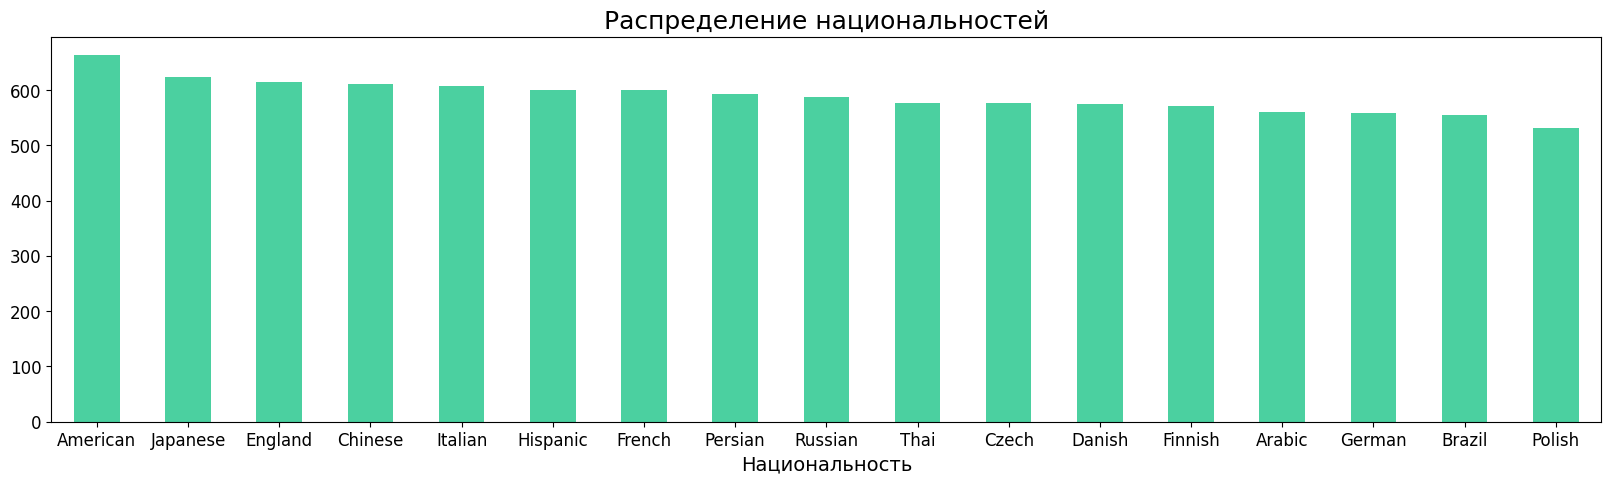

In [ ]:
ax = classes.plot.bar(rot = 0, color = '#4bd0a0')
ax.set_title('Распределение национальностей', fontsize = 18)
ax.set_xlabel('Национальность', fontsize = 14)

Построим облако слов для фамилий разных национальностей

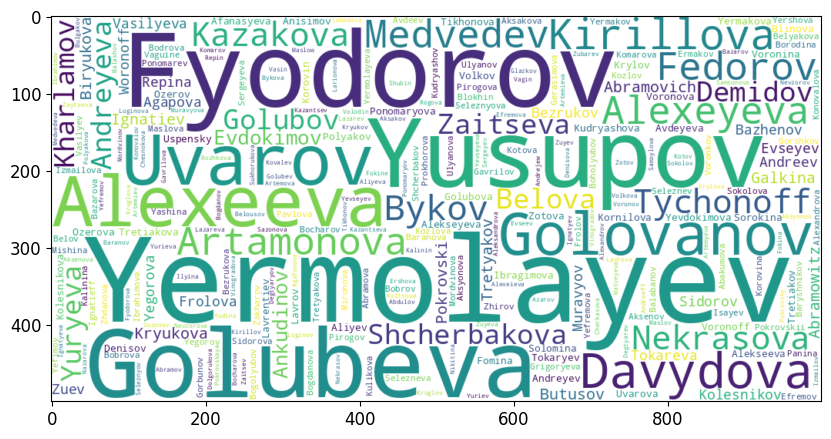

In [ ]:
plt.figure(figsize = (10, 5))
wc = WordCloud(background_color = 'white', max_words = 1000, width = 1000, height = 500).generate(' '.join(df_[df_['Nationality'] == 'Russian']['Surname']))
plt.imshow(wc, interpolation = 'bilinear')

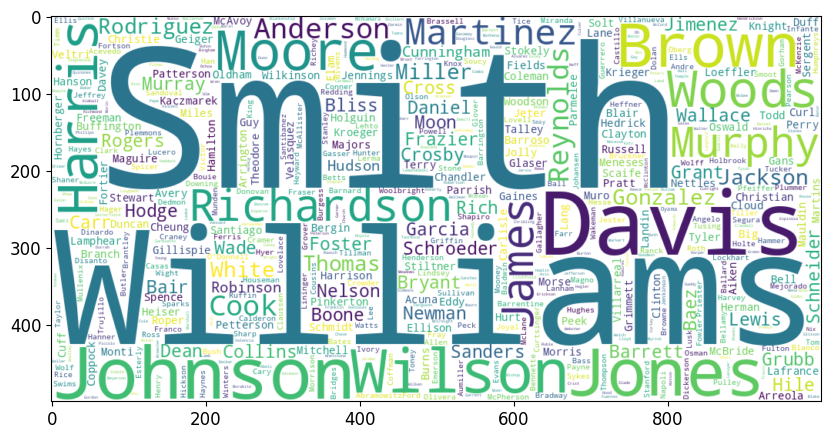

In [ ]:
plt.figure(figsize = (10, 5))
wc = WordCloud(background_color = 'white', max_words = 1000, width = 1000, height = 500).generate(' '.join(df_[df_['Nationality'] == 'American']['Surname']))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
def word2ngrams_3(text, n = 3, exact = True):
  return [''.join(j) for j in zip(*[text[i:] for i in range(n)])]

In [ ]:
def get_ngrams(d):
  ngram_freq = {}
  for item in d.to_list():
    for ngram in word2ngrams_3(item):
      if ngram not in ngram_freq:
        ngram_freq[ngram] = 1
      else:
        ngram_freq[ngram] += 1
  return ngram_freq

In [ ]:
ngrams = get_ngrams(df_[df_['Nationality'] == 'Russian']['Surname'])

In [ ]:
result = pd.DataFrame()
for nationality in ['Russian', 'American', 'Finnish', 'German', 'French', 'Hispanic']:
  dict_ = {'3-gram'+'_'+nationality: [], 'Frequency'+'_'+nationality: []}
  ngrams = get_ngrams(df_[df_['Nationality'] == nationality]['Surname'])
  top = sorted(ngrams.items(), reverse = True, key = lambda item: item[1])[:10]
  for item in top:
    key, value = item
    dict_['3-gram'+'_'+nationality].append(key)
    dict_['Frequency'+'_'+nationality].append(value)
  ngrams_df = pd.DataFrame(dict_)
  result = pd.concat([result, ngrams_df], axis = 1, join = 'outer')

In [ ]:
result

,3-gram_Russian,Frequency_Russian,3-gram_American,Frequency_American,3-gram_Finnish,Frequency_Finnish,3-gram_German,Frequency_German,3-gram_French,Frequency_French,3-gram_Hispanic,Frequency_Hispanic
0,ova,202,son,58,nen,146,man,48,eau,60,rre,28
1,rov,82,ill,28,ine,70,Sch,43,ier,40,era,23
2,kov,81,lli,20,one,36,ann,42,ard,28,ado,22
3,eva,67,Wil,19,ala,32,ler,39,ois,26,arr,19
4,yev,65,ter,18,ain,31,ber,34,lle,26,ill,19
5,nov,65,ers,18,ari,28,ger,29,our,25,err,18
6,lov,54,arr,17,ane,27,sch,25,Cha,25,ero,18
7,oro,51,ton,15,kka,24,ner,25,ill,25,ara,18
8,ono,42,ing,15,ila,24,ter,23,aul,20,rez,18
9,mov,40,Smi,14,ola,20,ste,18,Mar,19,lla,17


Закодируем категориальный признак

In [ ]:
labelencoder = LabelEncoder()
df_['Label'] = labelencoder.fit_transform(df_['Nationality'])
df_.head()

,Name,Surname,Nationality,Label
0,Rhys,May,England,6
1,Arkhip,Bykov,Russian,15
2,Luke,Curl,American,0
3,Maya,Perry,England,6
4,Rudolph,Gorshkov,Russian,15


В качестве токенов будем рассматривать 2- и 3-граммы

In [ ]:
def word2ngrams_(text, n = 2, exact = True):
  return [''.join(j) for j in zip(*[text[i:] for i in range(n)])]+[''.join(j) for j in zip(*[text[i:] for i in range(n+1)])]

In [ ]:
def get_vocab(d):
  max_len = 0
  token_to_idx = {'<pad>': 0}
  index = 1
  for item in d.to_list():
    if len(item) > max_len:
      max_len = len(item)
    for token in word2ngrams_(item):
      if token not in token_to_idx:
        token_to_idx[token] = index
        index += 1
  vocab_len = index
  return token_to_idx, vocab_len, max_len

In [ ]:
class SetDataset(Dataset):
  def __init__(self, x, y, vocabulary):
    self.x = x
    self.y = y
    self.vocabulary = vocabulary

  def vectorize(self, item):
    vectorizer = CountVectorizer(vocabulary = self.vocabulary, analyzer = 'char', lowercase = False, ngram_range = (2, 3))
    return vectorizer.transform([item]).toarray()[0]

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    x_item = torch.tensor(self.vectorize(self.x.iloc[idx])).float()
    y_item = torch.tensor(self.y.iloc[idx])
    return (x_item, y_item)

Разделим данные на обучающее (80%) и тестовое (20%) подмножества. Создадим словари токенов для фамилий и имен, преобразуем данные в датасеты для использования библиотеки PyTorch

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_[['Surname', 'Name']], df_['Label'], test_size = 0.2, random_state = 14)

In [ ]:
token_to_idx_1, vocab_len_1, max_len_1 = get_vocab(df_['Surname'])
token_to_idx_2, vocab_len_2, max_len_2 = get_vocab(df_['Name'])

In [ ]:
train_set_1 = SetDataset(x_train['Surname'], y_train, token_to_idx_1)
test_set_1 = SetDataset(x_test['Surname'], y_test, token_to_idx_1)

train_set_2 = SetDataset(x_train['Name'], y_train, token_to_idx_2)
test_set_2 = SetDataset(x_test['Name'], y_test, token_to_idx_2)

In [ ]:
batch_size = 256
train_loader_1 = DataLoader(train_set_1, batch_size = batch_size)
test_loader_1 = DataLoader(test_set_1, batch_size = batch_size)

train_loader_2 = DataLoader(train_set_2, batch_size = batch_size)
test_loader_2 = DataLoader(test_set_2, batch_size = batch_size)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def model(vocab_len, train_loader, train_set, test_loader, test_set):
  net = nn.Sequential(
    nn.Linear(vocab_len, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, len(labelencoder.classes_))).to(device)

  optimizer = optim.Adam(net.parameters(), lr = 0.005)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
  criterion = nn.CrossEntropyLoss()

  loss_values = []
  epochs = 30
  for epoch in range(epochs):
    running_loss = 0
    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      loss = criterion(net(x), y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    scheduler.step()
    loss_value = running_loss / len(train_set)
    loss_values.append(loss_value)
    print(f'Epoch: {epoch}, loss: {loss_value}')

  plt.plot(loss_values, color = '#4bd0a0')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  correct = 0
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    correct += (net(x).argmax(dim = 1) == y).sum().item()
  print(f'Accuracy: {correct / len(test_set) * 100:.2f}%')
  return net

In [ ]:
rcParams['figure.figsize'] = 8, 5
rcParams['font.size'] = 12

Обучим модель для определения национальности только по фамилии

Epoch: 0, loss: 0.005566540472209454
Epoch: 1, loss: 0.0012317911740392447
Epoch: 2, loss: 0.0006210222039371729
Epoch: 3, loss: 0.000448570191860199
Epoch: 4, loss: 0.0003543412075378001
Epoch: 5, loss: 0.00032392186438664794
Epoch: 6, loss: 0.00029220701032318177
Epoch: 7, loss: 0.00026743074180558325
Epoch: 8, loss: 0.0002412239508703351
Epoch: 9, loss: 0.00022781676496379079
Epoch: 10, loss: 0.00021309911529533566
Epoch: 11, loss: 0.0001903345244936645
Epoch: 12, loss: 0.00018275971431285144
Epoch: 13, loss: 0.00017948253662325442
Epoch: 14, loss: 0.00017764000105671584
Epoch: 15, loss: 0.00017581953131593764
Epoch: 16, loss: 0.00017457436490803956
Epoch: 17, loss: 0.00017358520277775823
Epoch: 18, loss: 0.00017268117261119186
Epoch: 19, loss: 0.0001719390591606498
Epoch: 20, loss: 0.00016561282146722078
Epoch: 21, loss: 0.00016422707284800708
Epoch: 22, loss: 0.00016369119565933944
Epoch: 23, loss: 0.00016348118579480797
Epoch: 24, loss: 0.00016336772008799017
Epoch: 25, loss: 0.0

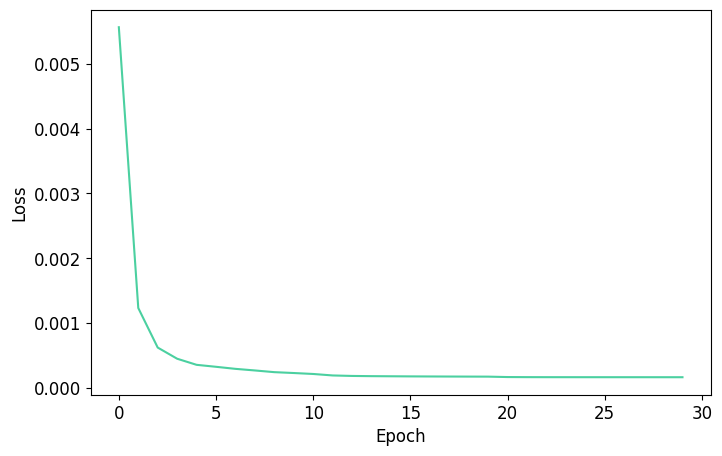

Accuracy: 88.65%


In [ ]:
net_surname = model(vocab_len_1, train_loader_1, train_set_1, test_loader_1, test_set_1)

Протестируем полученную модель

In [ ]:
group_surnames = pd.Series(['Bezrukov', 'Komarova', 'Hauta-aho', 'Chu'])
group_labels = pd.Series(labelencoder.transform(['Russian', 'Russian', 'Finnish', 'Chinese']))
groupset = SetDataset(group_surnames, group_labels, token_to_idx_1)

for (surname_vec, label), surname in zip(groupset, group_surnames):
  surname_vec = surname_vec.to(device)
  label = label.to(device)
  y_pred = net_surname(surname_vec)
  labels = y_pred.argsort(descending = True)[:3]
  probabilities = torch.softmax(y_pred, dim = 0).sort(descending = True)[0][:3]
  print(surname)
  for label, probability in zip(labels, probabilities):
    print(f'{labelencoder.classes_[label]} ({probability * 100:.2f}%)')
  print()

Bezrukov
Russian (100.00%)
Japanese (0.00%)
Hispanic (0.00%)

Komarova
Russian (100.00%)
Arabic (0.00%)
Japanese (0.00%)

Hauta-aho
Finnish (99.99%)
American (0.01%)
German (0.00%)

Chu
Chinese (99.97%)
American (0.02%)
Japanese (0.00%)



Теперь обучим модель для определения национальности по имени

Epoch: 0, loss: 0.007691212400794029
Epoch: 1, loss: 0.0033802427947521208
Epoch: 2, loss: 0.0022053351737558844
Epoch: 3, loss: 0.0018124433159828186
Epoch: 4, loss: 0.0016105363089591264
Epoch: 5, loss: 0.0014940142594277858
Epoch: 6, loss: 0.0013582435492426157
Epoch: 7, loss: 0.0012865525912493466
Epoch: 8, loss: 0.0011916170883923768
Epoch: 9, loss: 0.0011443001050502062
Epoch: 10, loss: 0.0010093979947268963
Epoch: 11, loss: 0.0009242697842419147
Epoch: 12, loss: 0.0009044647999107838
Epoch: 13, loss: 0.0008919937256723642
Epoch: 14, loss: 0.0008840876612812281
Epoch: 15, loss: 0.0008784231878817082
Epoch: 16, loss: 0.0008743984308093786
Epoch: 17, loss: 0.0008713466189801693
Epoch: 18, loss: 0.0008689735475927591
Epoch: 19, loss: 0.0008671404663473368
Epoch: 20, loss: 0.0008407944478094578
Epoch: 21, loss: 0.0008396834805607796
Epoch: 22, loss: 0.0008389794565737248
Epoch: 23, loss: 0.0008385073766112327
Epoch: 24, loss: 0.0008381240908056498
Epoch: 25, loss: 0.00083778472431004

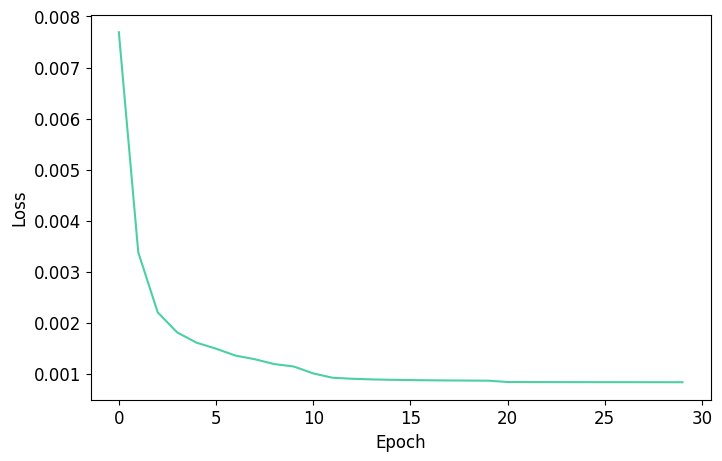

Accuracy: 73.95%


In [ ]:
net_name = model(vocab_len_2, train_loader_2, train_set_2, test_loader_2, test_set_2)

In [ ]:
group_names = pd.Series(['Nicephorus', 'Arina', 'Anniina', 'Huan Yue'])
group_labels = pd.Series(labelencoder.transform(['Russian', 'Russian', 'Finnish', 'Chinese']))
groupset = SetDataset(group_names, group_labels, token_to_idx_2)

for (name_vec, label), name in zip(groupset, group_names):
  name_vec = name_vec.to(device)
  label = label.to(device)
  y_pred = net_name(name_vec)
  labels = y_pred.argsort(descending = True)[:3]
  probabilities = torch.softmax(y_pred, dim = 0).sort(descending = True)[0][:3]
  print(name)
  for label, probability in zip(labels, probabilities):
    print(f'{labelencoder.classes_[label]} ({probability * 100:.2f}%)')
  print()

Nicephorus
Russian (100.00%)
French (0.00%)
Hispanic (0.00%)

Arina
Japanese (99.52%)
Hispanic (0.31%)
Finnish (0.07%)

Anniina
Finnish (100.00%)
Czech (0.00%)
Japanese (0.00%)

Huan Yue
Chinese (100.00%)
Hispanic (0.00%)
Arabic (0.00%)



Используем обученные модели совместно для определения национальности по фамилии и имени одновременно

In [ ]:
group_surnames = pd.Series(['Bezrukov', 'Komarova', 'Hauta-aho', 'Chu'])
group_labels = pd.Series(labelencoder.transform(['Russian', 'Russian', 'Finnish', 'Chinese']))
groupset_1 = SetDataset(group_surnames, group_labels, token_to_idx_1)

group_names = pd.Series(['Nicephorus', 'Arina', 'Anniina', 'Huan Yue'])
groupset_2 = SetDataset(group_names, group_labels, token_to_idx_2)

for (surname_vec, label), surname, (name_vec, label), name in zip(groupset_1, group_surnames, groupset_2, group_names):
  surname_vec = surname_vec.to(device)
  name_vec = name_vec.to(device)
  label = label.to(device)
  y_pred_1 = net_surname(surname_vec)
  y_pred_2 = net_name(name_vec)
  labels_1 = y_pred_1.argsort(descending = True)[:3]
  labels_2 = y_pred_2.argsort(descending = True)[:3]
  probabilities_1 = torch.softmax(y_pred_1, dim = 0).sort(descending = True)[0][:3]
  probabilities_2 = torch.softmax(y_pred_2, dim = 0).sort(descending = True)[0][:3]
  label = (y_pred_1 + y_pred_2).argsort(descending = True)[:3]
  prob = torch.softmax(y_pred_1, dim = 0) * torch.softmax(y_pred_2, dim = 0)
  print(surname, name)
  print(f'{labelencoder.classes_[label[0]]} ({prob.sort(descending = True)[0][0] * 100:.2f}%)')
  for label_1, probability_1 in zip(labels_1, probabilities_1):
    print(f'{labelencoder.classes_[label_1]} ({probability_1 * 100:.2f}%)')
  print()
  for label_2, probability_2 in zip(labels_2, probabilities_2):
    print(f'{labelencoder.classes_[label_2]} ({probability_2 * 100:.2f}%)')
  print()

Bezrukov Nicephorus
Russian (100.00%)
Russian (100.00%)
Japanese (0.00%)
Hispanic (0.00%)

Russian (100.00%)
French (0.00%)
Hispanic (0.00%)

Komarova Arina
Russian (0.03%)
Russian (100.00%)
Arabic (0.00%)
Japanese (0.00%)

Japanese (99.52%)
Hispanic (0.31%)
Finnish (0.07%)

Hauta-aho Anniina
Finnish (99.99%)
Finnish (99.99%)
American (0.01%)
German (0.00%)

Finnish (100.00%)
Czech (0.00%)
Japanese (0.00%)

Chu Huan Yue
Chinese (99.97%)
Chinese (99.97%)
American (0.02%)
Japanese (0.00%)

Chinese (100.00%)
Hispanic (0.00%)
Arabic (0.00%)



Протестируем полученную модель

In [ ]:
correct = 0
for (x1, y1), (x2, y2) in zip(test_loader_1, test_loader_2):
  x1 = x1.to(device)
  x2 = x2.to(device)
  y = y1.to(device)
  correct += ((net_surname(x1) + net_name(x2)).argmax(dim = 1) == y).sum().item()
print(f'Accuracy: {correct / len(test_set_2) * 100:.2f}%')

Accuracy: 93.25%
